In [50]:
import torch
import cv2
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from PIL import Image


import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm

In [51]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [52]:
print(np.shape(img1))
VAL_RATIO = 0.2

#The ratio of the total training set used only for validation

(1080, 1920, 3)


In [53]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Pad(3) # adds 6 to both the height and width to make it 256,256
])




dataset = torchvision.datasets.LFWPairs(root = "PyTorch\\",download="True",split="train", transform=transform)

INPUT_SHAPE = (3,250,250)
VAL_RATIO = 0.2
val_len = int(len(dataset) * VAL_RATIO)
train_len = len(dataset) - val_len

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_len, val_len])

print(val_len,train_len)


image1, image2, label = train_dataset[0]
image1.shape, image2.shape, label

Files already downloaded and verified
440 1760


(torch.Size([3, 256, 256]), torch.Size([3, 256, 256]), 1)

In [54]:
image.shape
len(train_dataset), len(train_dataset), len(val_dataset), len(val_dataset)

(1760, 1760, 440, 440)

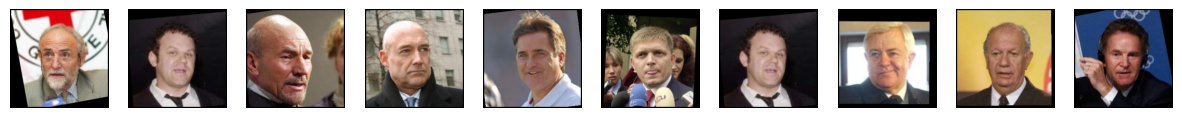

In [57]:
fig, axes = plt.subplots(1, 10, figsize=(15, 5))
idxs = torch.randperm(len(train_dataset))[:10] #10 random images
for i, ax in enumerate(axes):
    img, img2, label = train_dataset[idxs[i]]
    ax.imshow(img.cpu().permute(1,2,0)) #moves dimensions 3,250,250 --> 250,250,3
    ax.axis('off')
plt.show()

In [58]:
BATCH_SIZE = 127

In [59]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device 

device(type='cpu')

In [60]:
class Encoder(nn.Module):
    def __init__(self, features):
        super().__init__()
        self.img_size = (3,256,256)

        self.encoder = nn.Sequential(

            nn.Conv2d(self.img_size[0], features*8, (3,3), (1,1), 1),
            nn.BatchNorm2d(features*8),
            nn.ReLU(),

            self._enc_block(features*8 , features*16),
            self._enc_block(features*16, features*16),
            self._enc_block(features*16, features*32),
            self._enc_block(features*32, features*16),
            self._enc_block(features*16, features*16),
             
              #256x4x4

            nn.Flatten(),
            nn.Linear(features*16*8*8, 1024),
            nn.ReLU(),
            nn.Linear(1024, 128),
            #nn.Softmax(dim=1), #Normalise

        )


    def _enc_block(self, in_channels, out_channels, kernel_size = 3, stride = 1, padding = 1):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False
            ),
            nn.MaxPool2d(kernel_size = 2),
            nn.BatchNorm2d(out_channels), #normalises data
            nn.ReLU6(),
            nn.Dropout(0.1),
        )

    def forward(self, images):
        return self.encoder(images)
    

In [61]:

model = Encoder(8)
image1, image2 , label = train_dataset[0]
model(image1.unsqueeze(0)).shape
lossarray = []

In [65]:
batchsize = 16
num_epochs = 10
traindataloader = DataLoader(train_dataset, batchsize, shuffle=True)
for epoch in range(num_epochs):
    loop = tqdm(traindataloader, leave=False, total = len(traindataloader))
   
    if epoch > 0:
        loop.set_description(f"Epoch : {epoch}/{num_epochs}")
        loop.set_postfix({"Loss" : lossarray[-1]})
    
    batchlosses = []

    for (images1, images2, labels) in traindataloader:
        images1 = images1.to(device)
        images2 = images2.to(device)
        labels = labels.to(device)
        out1 = model(images1)
        out2 = model(images2)
        labels = (labels - 0.5)*2 
        loss = F.mse_loss(out1, out2, reduction="none").mean()*labels
        loss.mean().backward() # backward needs to be done on a vector object and mean reduces the dimensions of the loss.
        batchlosses.append(loss.item()) #gives the value rather than the object

    lossarray.append(sum(batchlosses)/len(batchlosses))





  0%|          | 0/110 [00:00<?, ?it/s]

: 